In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')
byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv')
path_to_file_server = 'data/byrd_bedmachine.nc'
byrd_bedmachine = xr.open_dataset(path_to_file_server)

In [3]:
byrd_bedmachine.bed.values.shape

(400, 400)

# Count per grid cell

Assign IDs and groupby pixel IDs to then compute std, count and mean
Sample minimum one per grid cell

In [5]:
byrd_bedmap_points_assigned = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_assigned_to_pixels.csv')

## Create IDs

In [6]:
# Make categocial column based on grid cell index
byrd_bedmap_points_assigned["id_500"] = byrd_bedmap_points_assigned["x_pixel_center"].astype(int).astype(str) + "_" + byrd_bedmap_points_assigned["y_pixel_center"].astype(int).astype(str)

# Group by

400 x 400 cells  
16.8% contain measurements.

In [7]:
# Rate of grid cells with assigned points
byrd_bedmap_points_assigned.groupby("id_500").size().sort_values(ascending = False).shape[0]/(400*400)

0.16821875

In [9]:
means_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").mean()

std_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").std()
# std is NaN for grid cells with only one point assigned

sem_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").sem()
# std / np.art(count)

count_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").count()

combined_metrics = pd.DataFrame(means_per_pixel.index.values, columns = ["center_index"])
combined_metrics["t_mean"] = means_per_pixel["t"].values
combined_metrics["t_std"] = std_per_pixel["t"].values
combined_metrics["t_count"] = count_per_pixel["t"].values
combined_metrics["t_sem"] = sem_per_pixel["t"].values

combined_metrics

,center_index,t_mean,t_std,t_count,t_sem
0,350000_-980000,95.892778,5.365275,18,1.264607
1,350000_-990500,640.070000,NaN,1,NaN
2,350000_-991000,670.948182,17.315805,11,5.220912
3,350000_-999000,744.478000,3.212053,10,1.015740
4,350500_-980000,88.767143,3.491351,35,0.590146
...,...,...,...,...,...
26910,549500_-931000,1814.238750,6.377909,8,2.254931
26911,549500_-931500,1841.431818,11.084475,11,3.342095
26912,549500_-972500,2167.790000,2.540020,9,0.846673
26913,549500_-997500,1115.707500,6.228084,4,3.114042


In [40]:
combined_metrics.to_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_assigned_to_pixels_mean.csv')

# Add this to a xarray dataset

In [10]:
centers = [i.split("_") for i in combined_metrics.center_index.values.astype(str)]

# Add standard error of the mean
combined_metrics["t_sem_check"] = combined_metrics["t_std"] / np.sqrt(combined_metrics["t_count"])

# Add column one and 2
combined_metrics["x"] = np.array(centers).astype(int)[:, 0]
combined_metrics["y"] = np.array(centers).astype(int)[:, 1]

# Mean error per gridcell (median is only 9 m)
# Screwed: remote cells with super high std
combined_metrics.t_std.mean()
combined_metrics.t_std.describe()

count    25940.000000
mean        16.292397
std         23.855972
min          0.000000
25%          4.380914
50%          9.460938
75%         19.019378
max        542.925992
Name: t_std, dtype: float64

Before preprocessing the t_std descriptive statistics over all gridcells were:

count    26260.000000  
mean        18.230413  
std         45.952715  
min          0.000000  
25%          4.392811  
50%          9.490620  
75%         19.132974  
max       1159.894840  
Name: t_std, dtype: float64


After: 

count    25940.000000  
mean        16.292397  
std         23.855972  
min          0.000000  
25%          4.380914  
50%          9.460938  
75%         19.019378  
max        542.925992  
Name: t_std, dtype: float64

In [38]:
combined_metrics.t_sem.describe()

count    25940.000000
mean         3.908212
std          5.562206
min          0.000000
25%          1.247189
50%          2.425957
75%          4.591219
max        181.625000
Name: t_sem, dtype: float64

The median gridding error over Byrd glacier for a 500 x 500 m grid is 9.5 meters.  
The mean gridding error over Byrd glacier for a 500 x 500 m grid is 16.3 meters.  
The mean SEM (standard error of the mean) over Byrd glacier for a 500 x 500 m grid is 3.9 meters.

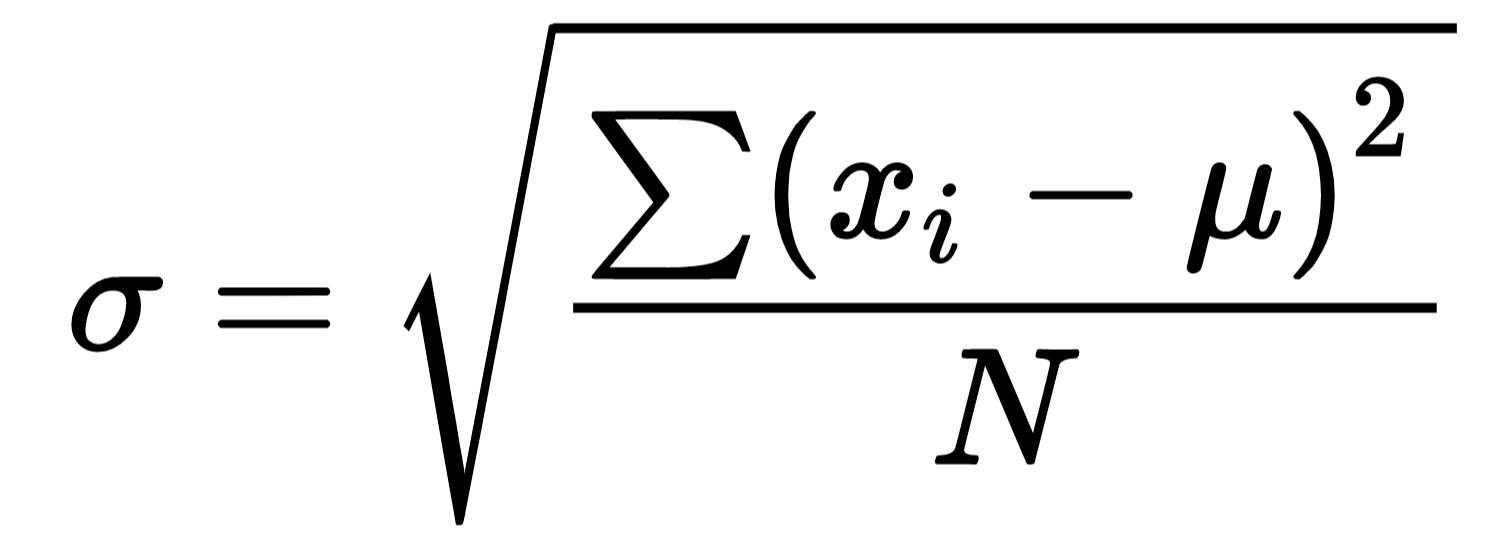

In [12]:
# Now there are only a few cells with high std
combined_metrics[combined_metrics.t_std > 300]

,center_index,t_mean,t_std,t_count,t_sem,t_sem_check,x,y
2922,393000_-974000,1642.513333,380.894646,6,155.499588,155.499588,393000,-974000
2923,393000_-974500,1431.631515,373.817716,33,65.073312,65.073312,393000,-974500
2924,393000_-975000,1515.698571,352.302944,21,76.878805,76.878805,393000,-975000
2980,393500_-973500,1831.268400,322.835236,25,64.567047,64.567047,393500,-973500
3083,394500_-970500,2080.867826,352.921020,23,73.589120,73.589120,394500,-970500
3134,395000_-968000,2162.981304,433.732492,23,90.439476,90.439476,395000,-968000
6265,417000_-936500,2095.644375,414.266657,16,103.566664,103.566664,417000,-936500
6448,418500_-939500,1938.961148,308.897659,61,39.550292,39.550292,418500,-939500
6827,421500_-928500,2132.555500,312.521071,20,69.881836,69.881836,421500,-928500
7038,423000_-927000,1910.948889,500.906321,27,96.399466,96.399466,423000,-927000


# Go from table to mesh

In [13]:
xx, yy = np.meshgrid(byrd_bedmachine.bed.x, byrd_bedmachine.bed.y)
flat_grid = pd.DataFrame({"x": xx.reshape(-1), "y": yy.reshape(-1)})

In [14]:
flat_grid

,x,y
0,350000,-800500
1,350500,-800500
2,351000,-800500
3,351500,-800500
4,352000,-800500
...,...,...
159995,547500,-1000000
159996,548000,-1000000
159997,548500,-1000000
159998,549000,-1000000


In [15]:
flat_grid_merged = flat_grid.merge(combined_metrics, on = ["x", "y"], how = "left")

In [16]:
flat_grid_merged

,x,y,center_index,t_mean,t_std,t_count,t_sem,t_sem_check
0,350000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
1,350500,-800500,NaN,NaN,NaN,NaN,NaN,NaN
2,351000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
3,351500,-800500,NaN,NaN,NaN,NaN,NaN,NaN
4,352000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
159995,547500,-1000000,547500_-1000000,1556.340769,131.891521,26.0,25.866055,25.866055
159996,548000,-1000000,548000_-1000000,1505.013571,187.765143,14.0,50.182345,50.182345
159997,548500,-1000000,NaN,NaN,NaN,NaN,NaN,NaN
159998,549000,-1000000,NaN,NaN,NaN,NaN,NaN,NaN


### Add to Xarray Dataset

In [17]:
byrd_bedmachine["pt_t_mean"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_mean"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_std"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_std"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_sem"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_sem"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_count"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_count"].values.reshape(byrd_bedmachine.bed.shape))

# Visualise

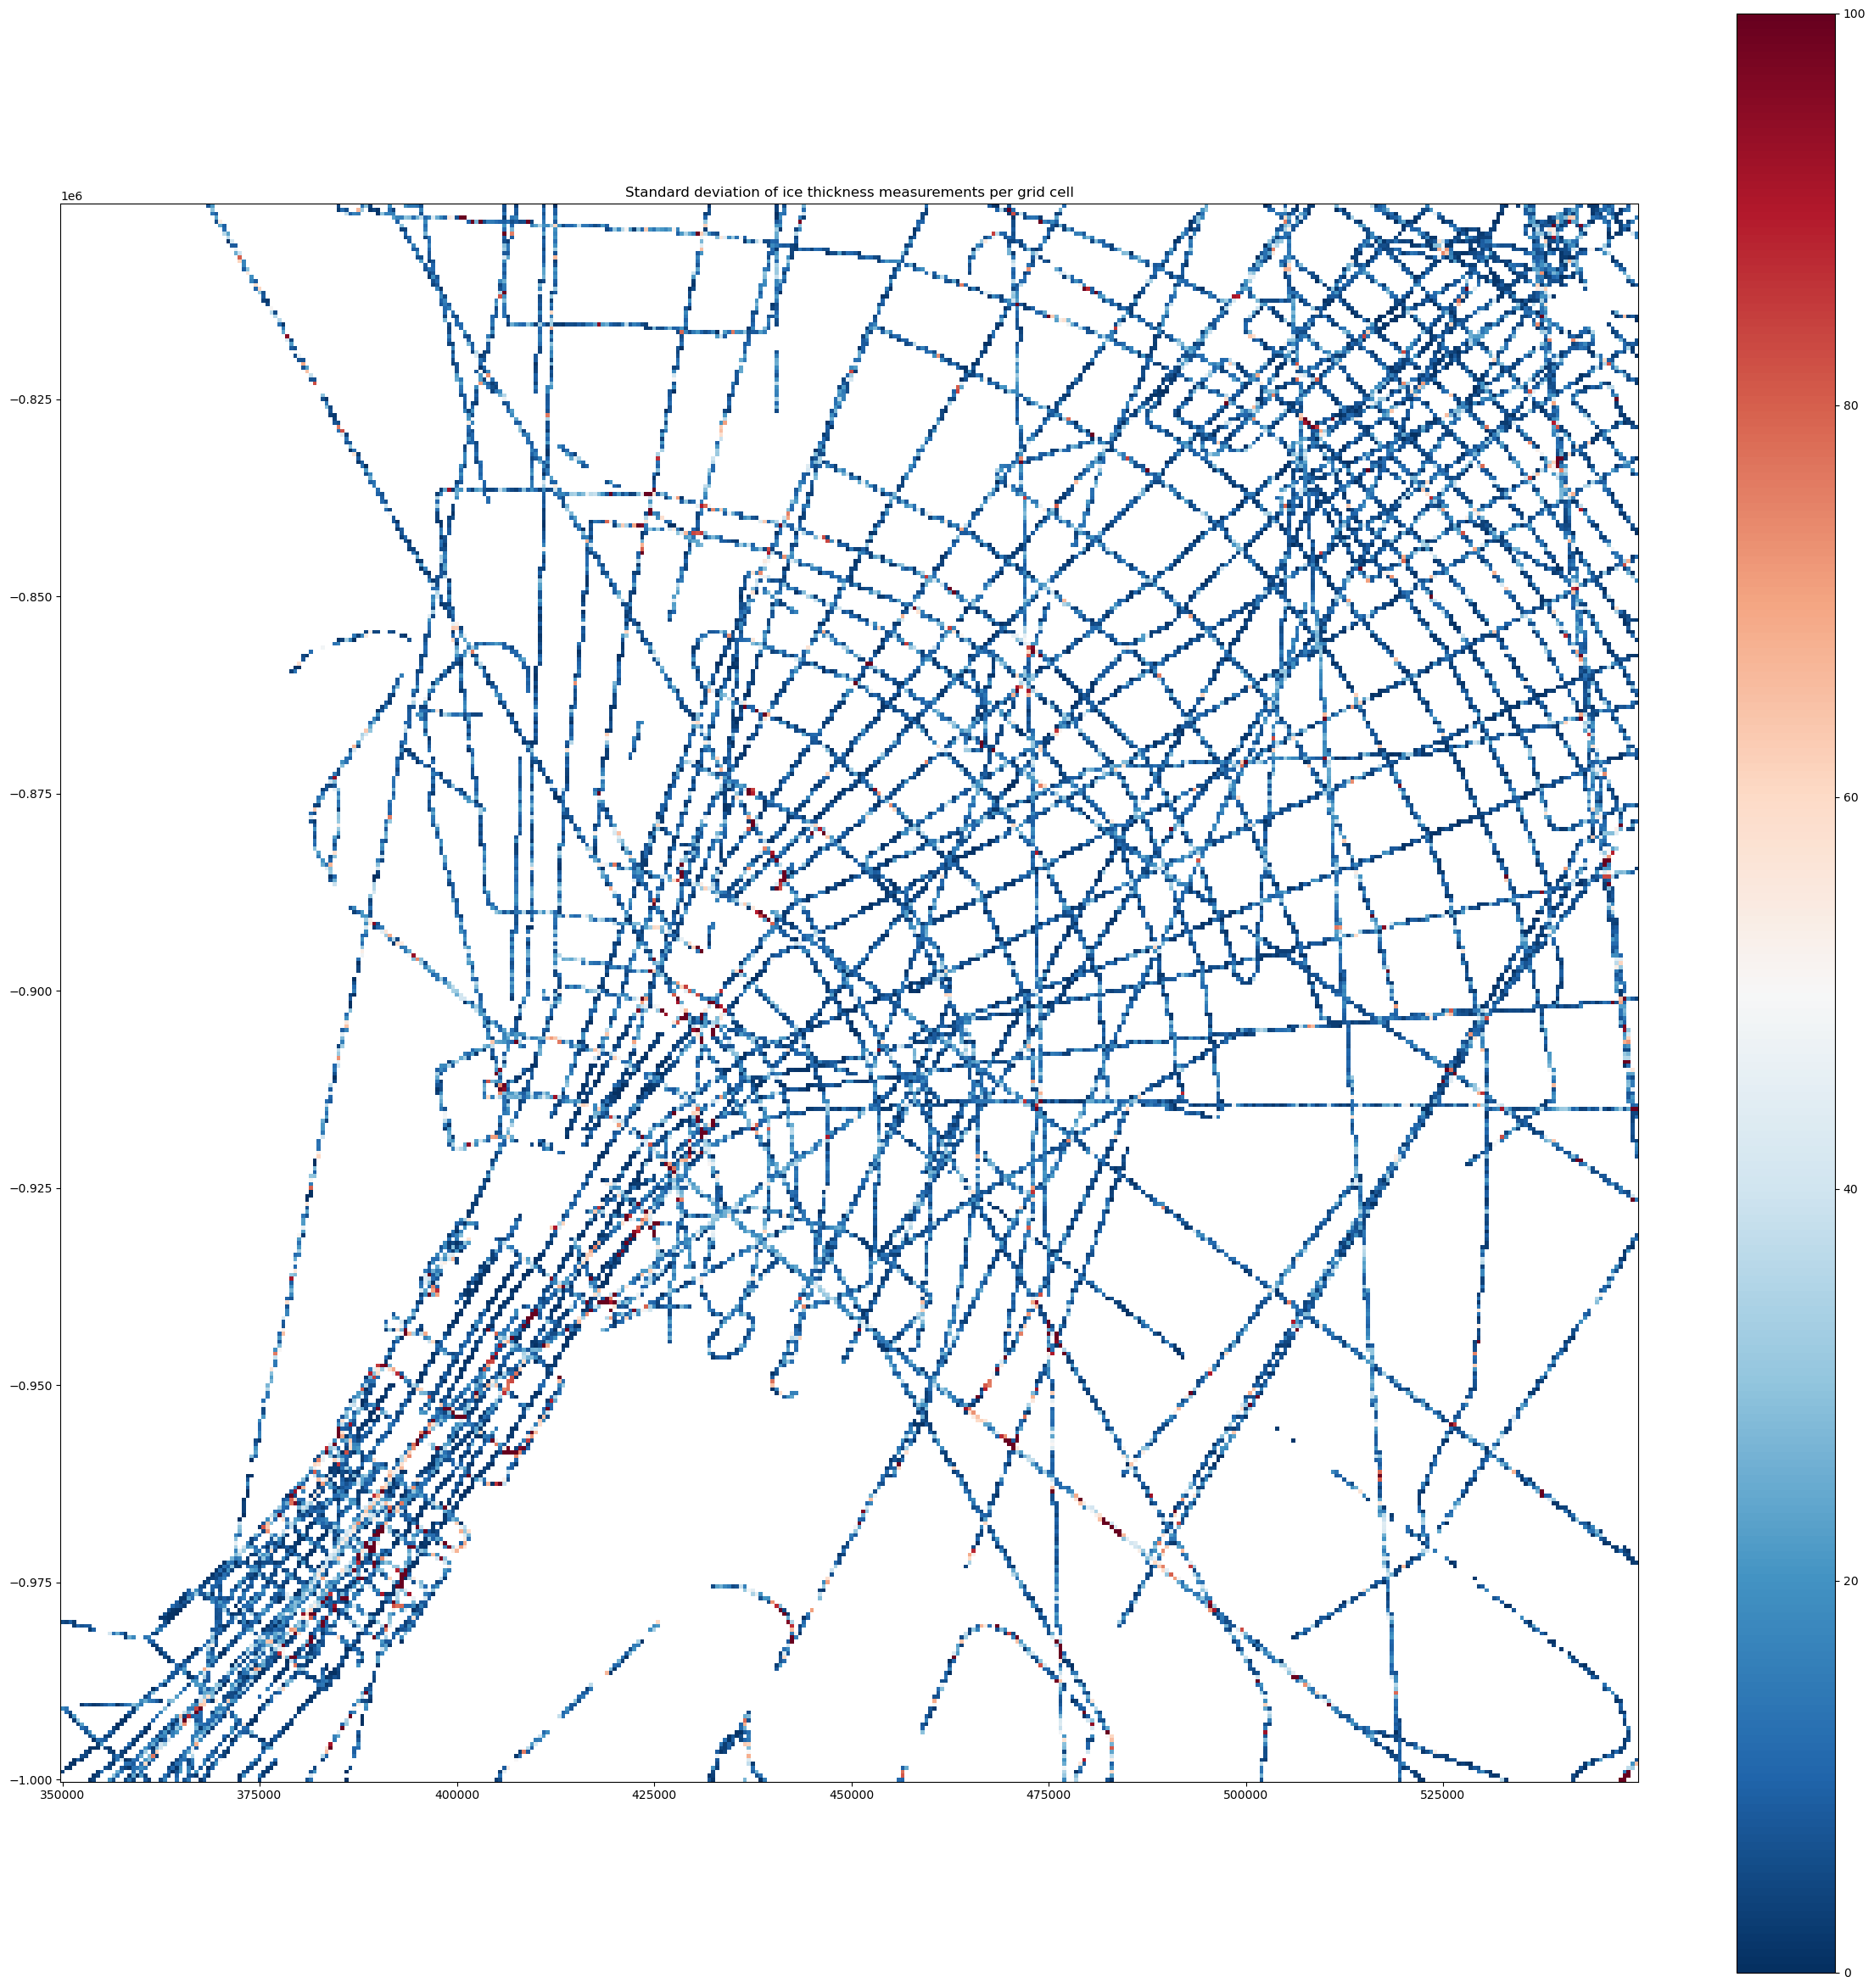

In [18]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_std, cmap = "RdBu_r", vmin = 0, vmax = 100)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Standard deviation of ice thickness measurements per grid cell')
ax.set_aspect('equal')

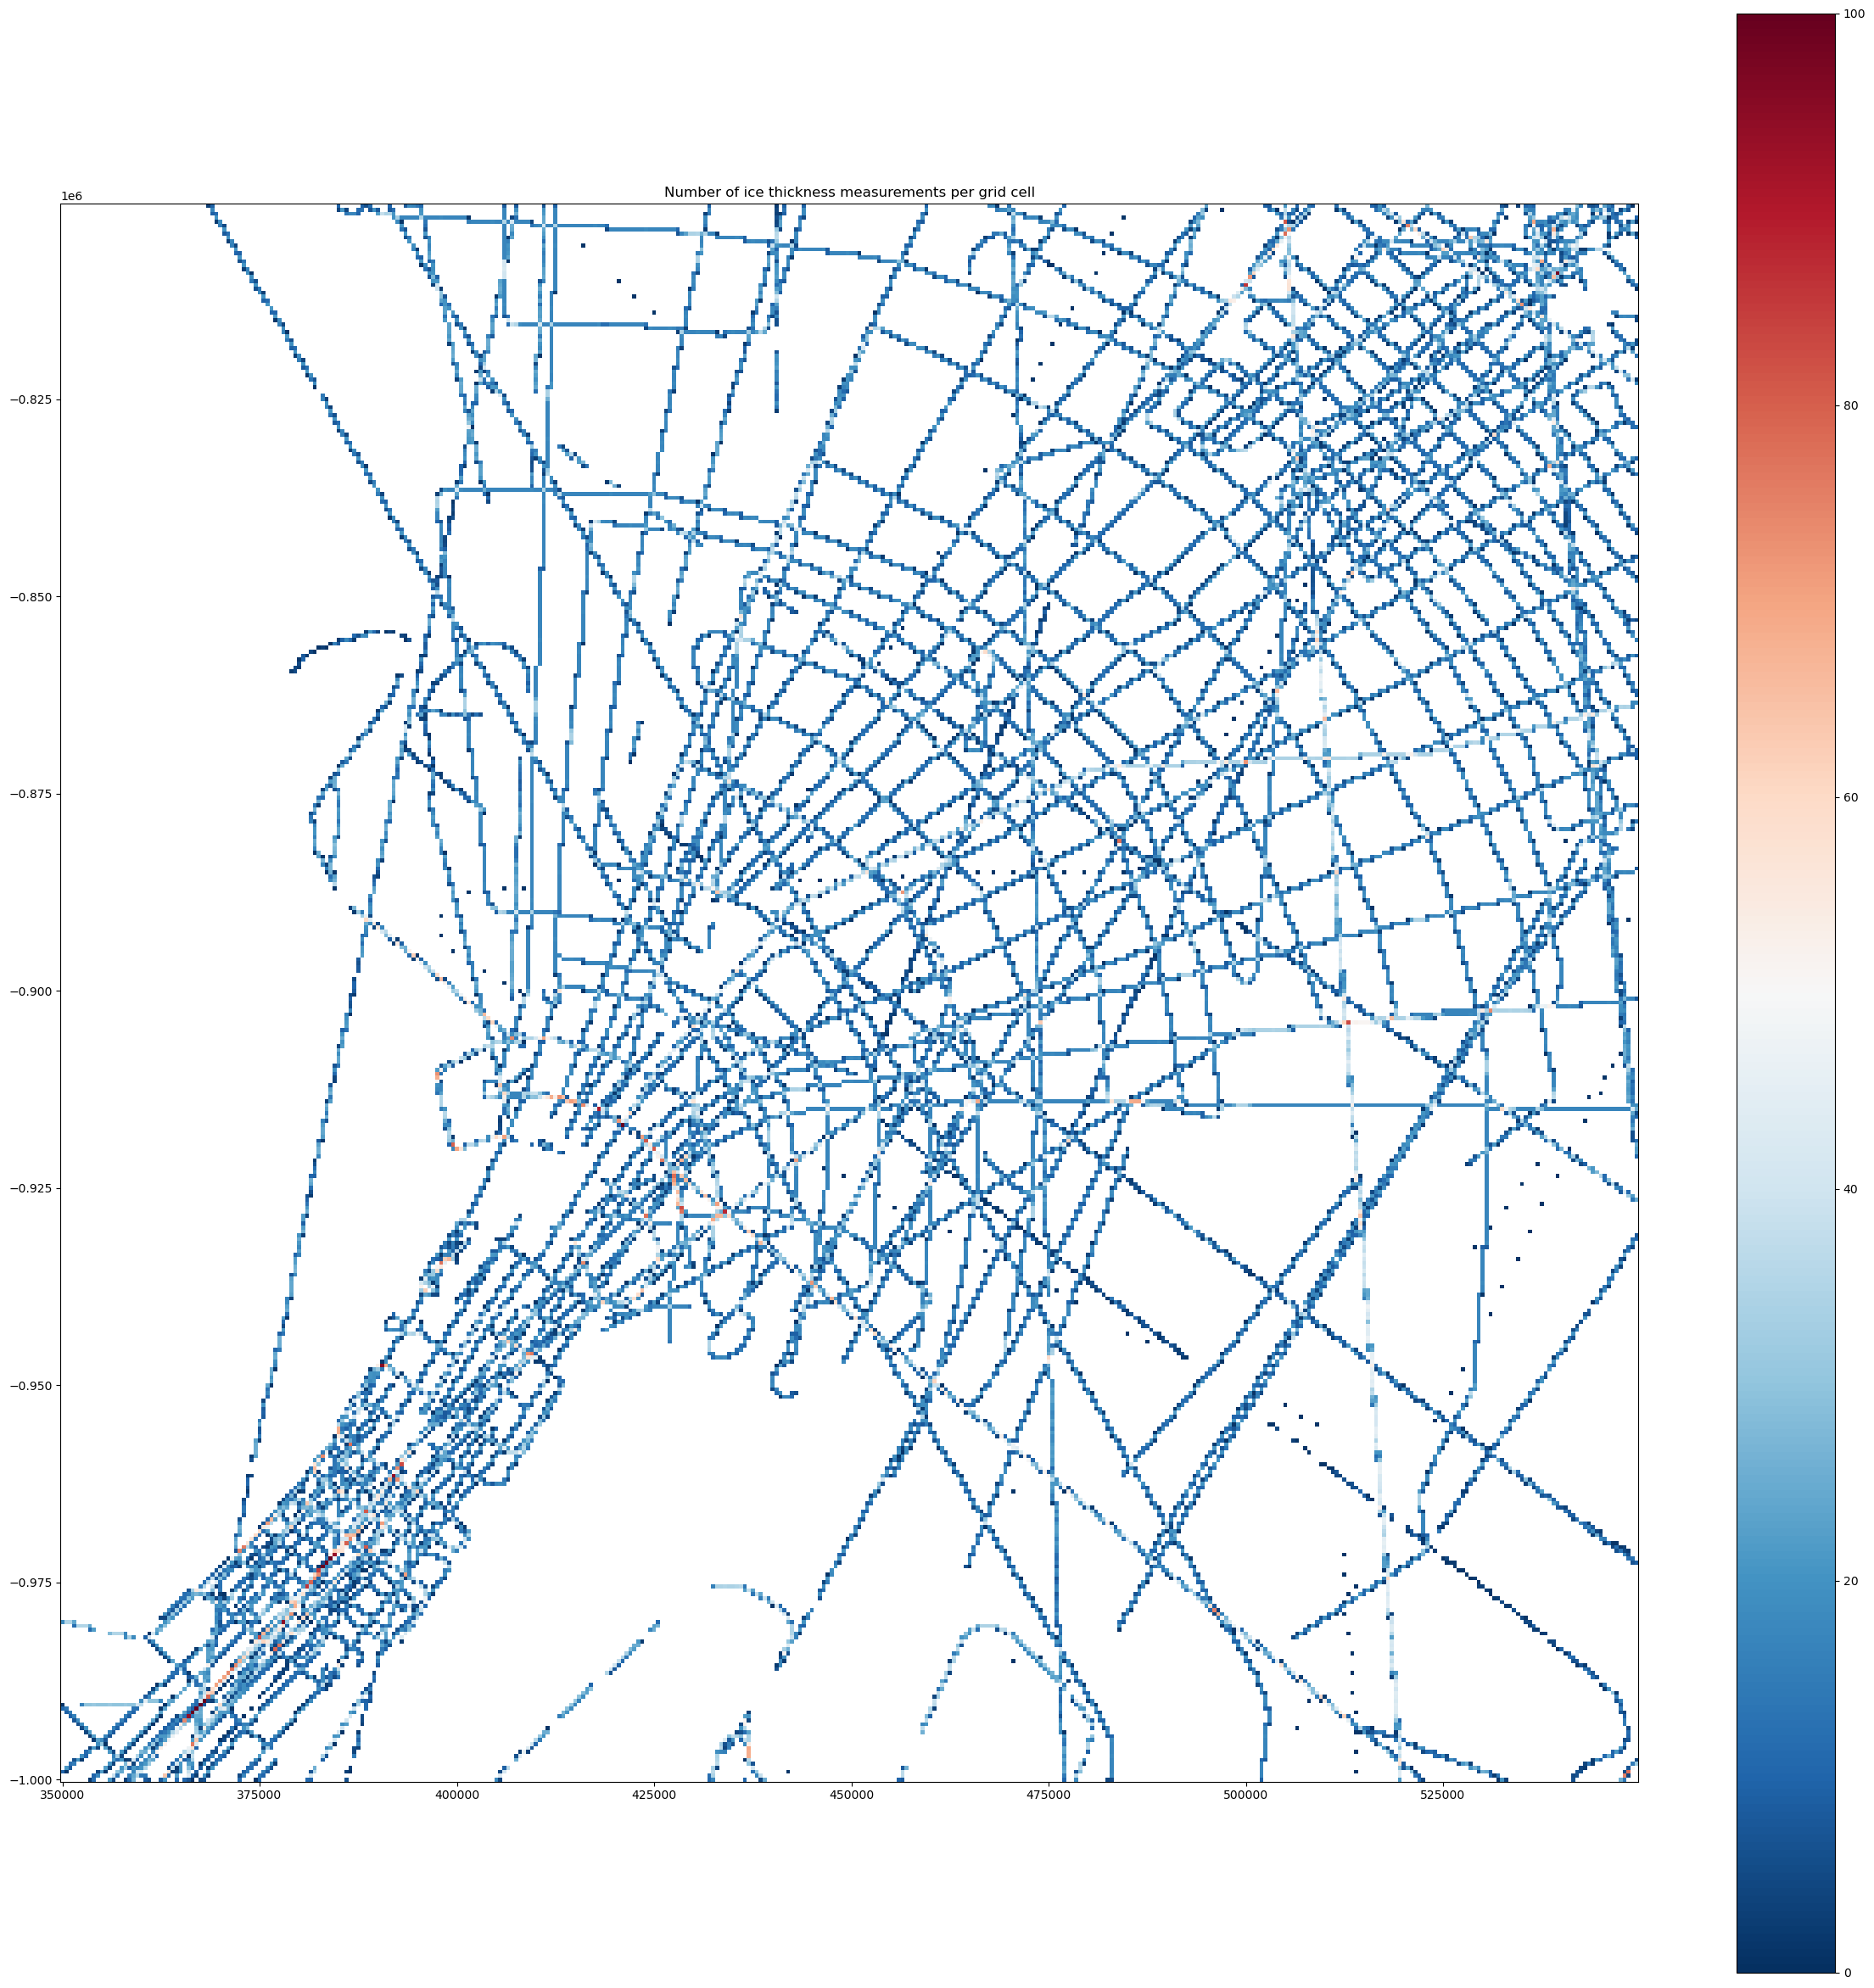

In [19]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_count, cmap = "RdBu_r", vmin = 0, vmax = 100)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Number of ice thickness measurements per grid cell')
ax.set_aspect('equal')

In [20]:
cvals  = [0, 
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

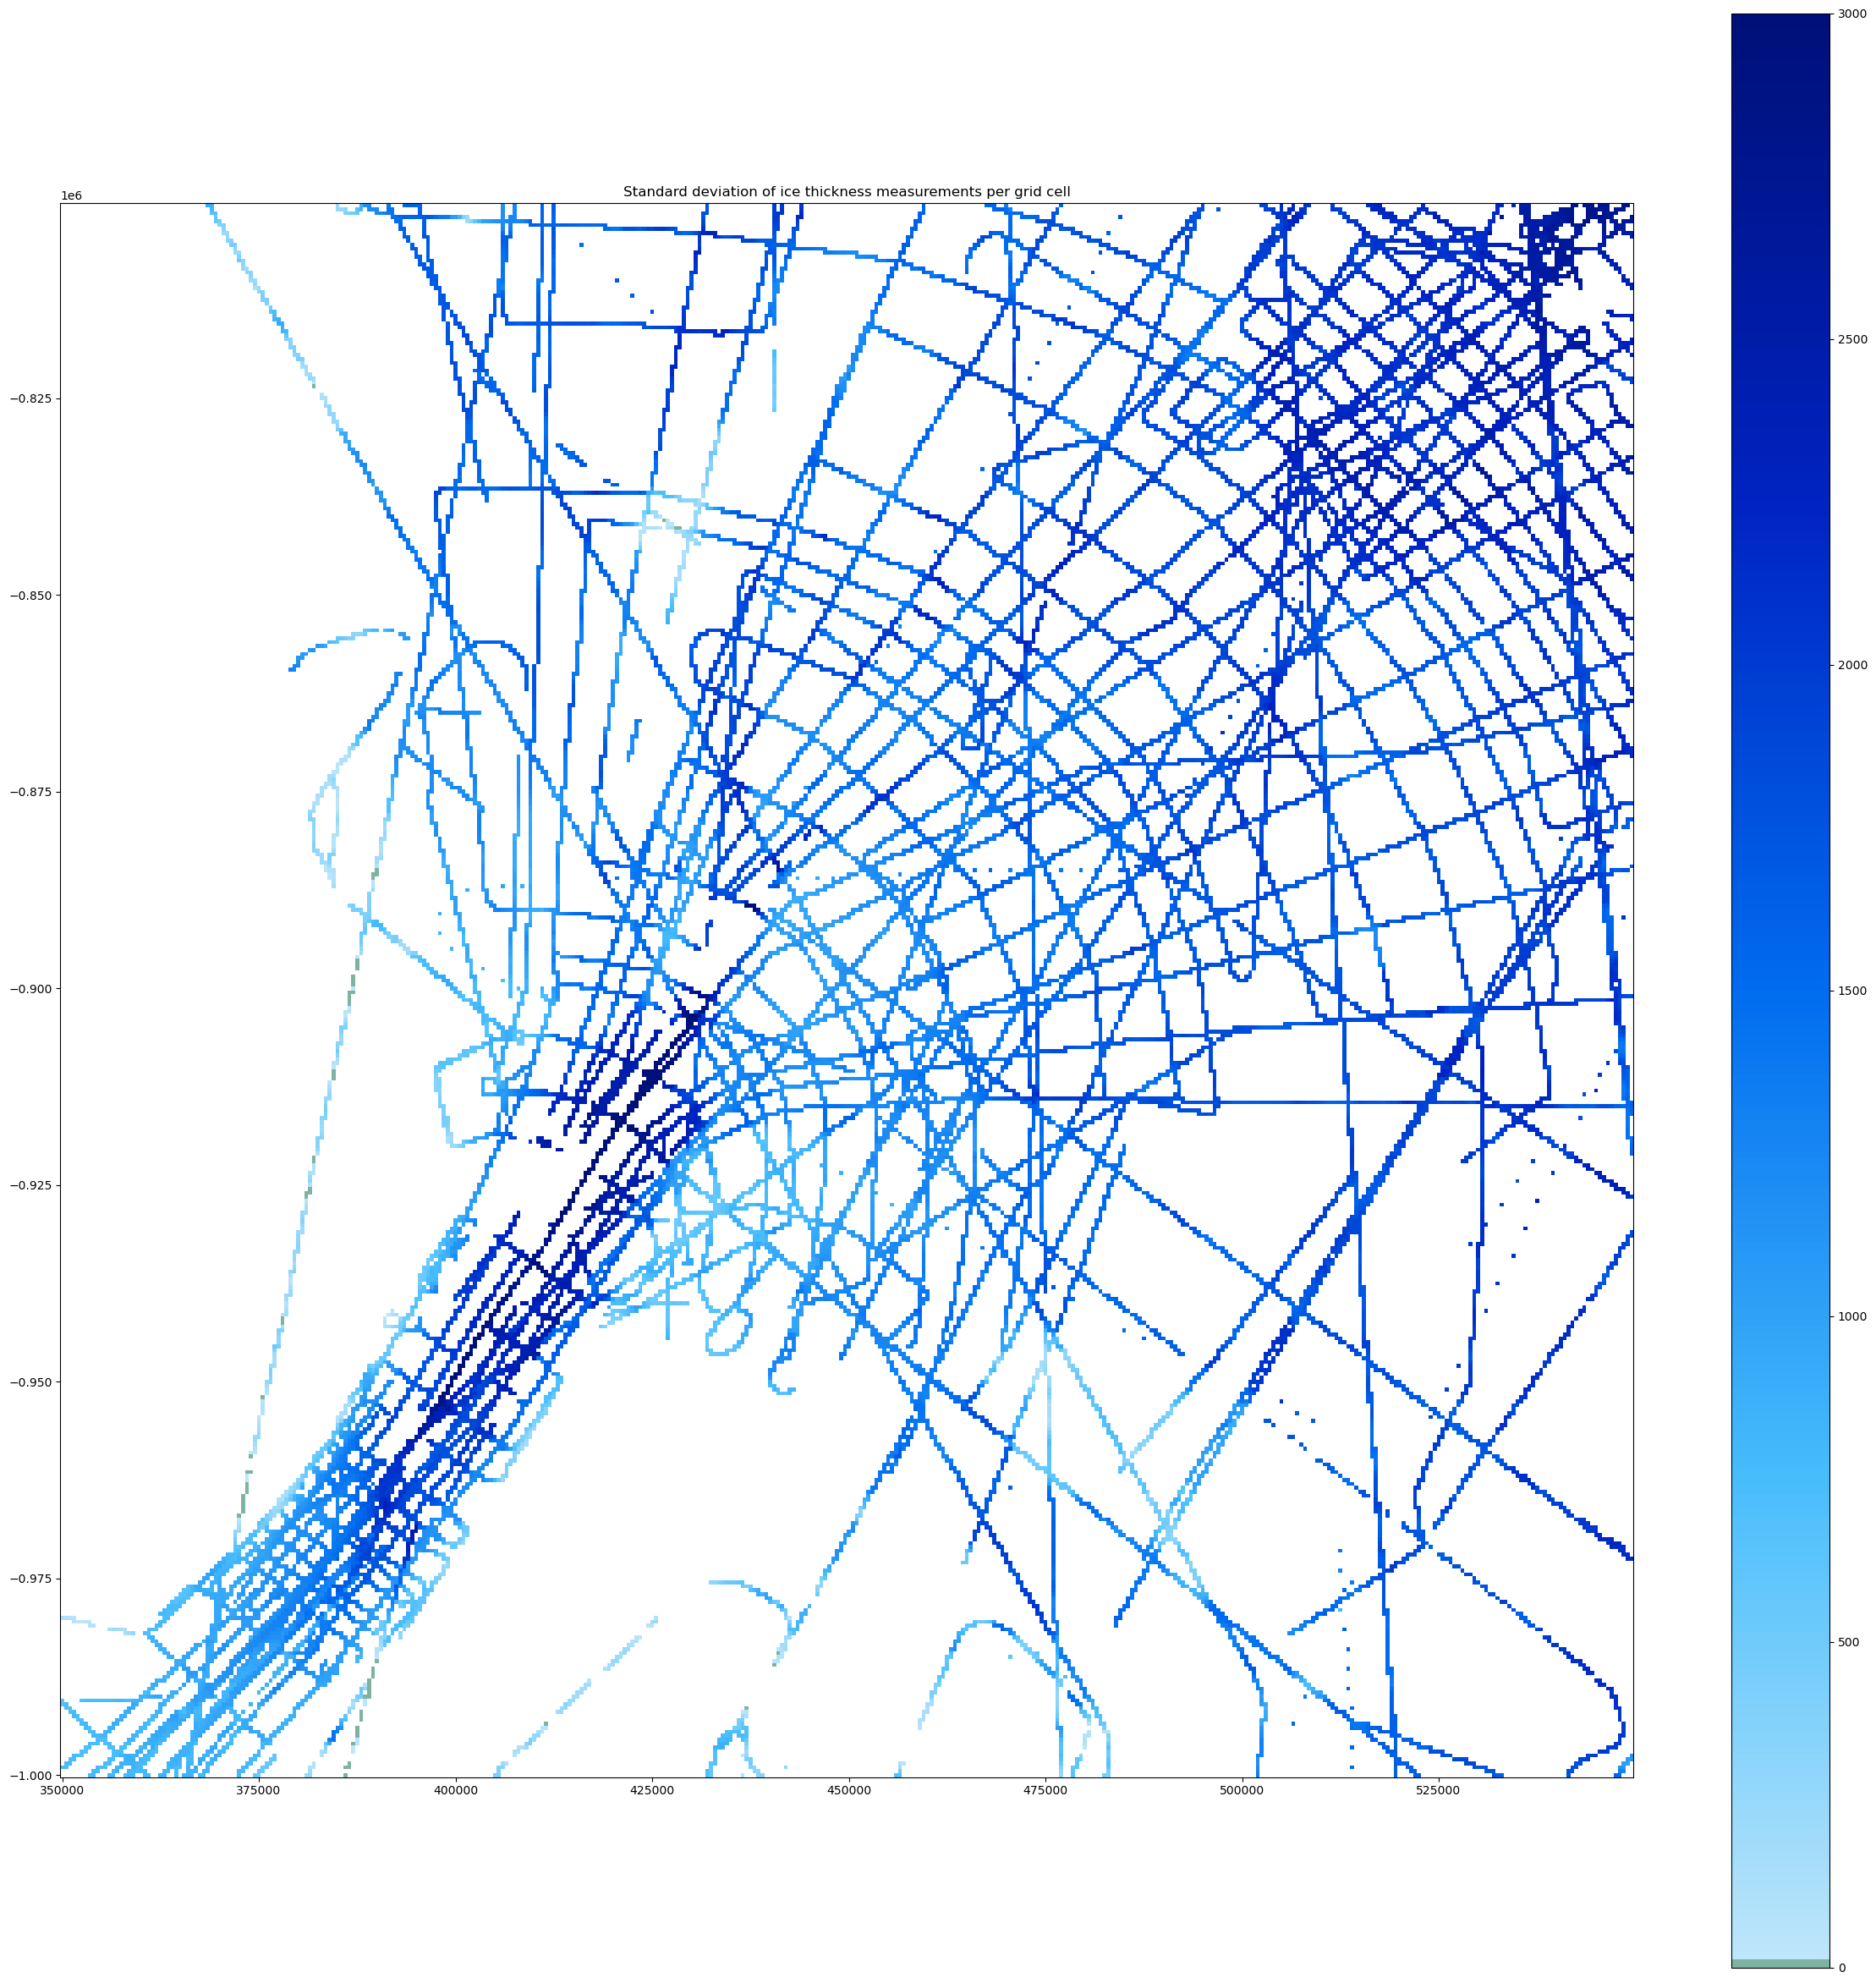

In [21]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_mean, cmap = icethickness_cmap, vmin = 0, vmax = 3000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Standard deviation of ice thickness measurements per grid cell')
ax.set_aspect('equal')

In [22]:
byrd_bedmachine["thickness_ellipsoid"] = byrd_bedmachine["thickness"] + byrd_bedmachine["geoid"]
byrd_bedmachine["thickness_ellipsoid_true"] = byrd_bedmachine["thickness_ellipsoid"] + byrd_bedmachine["firn"]

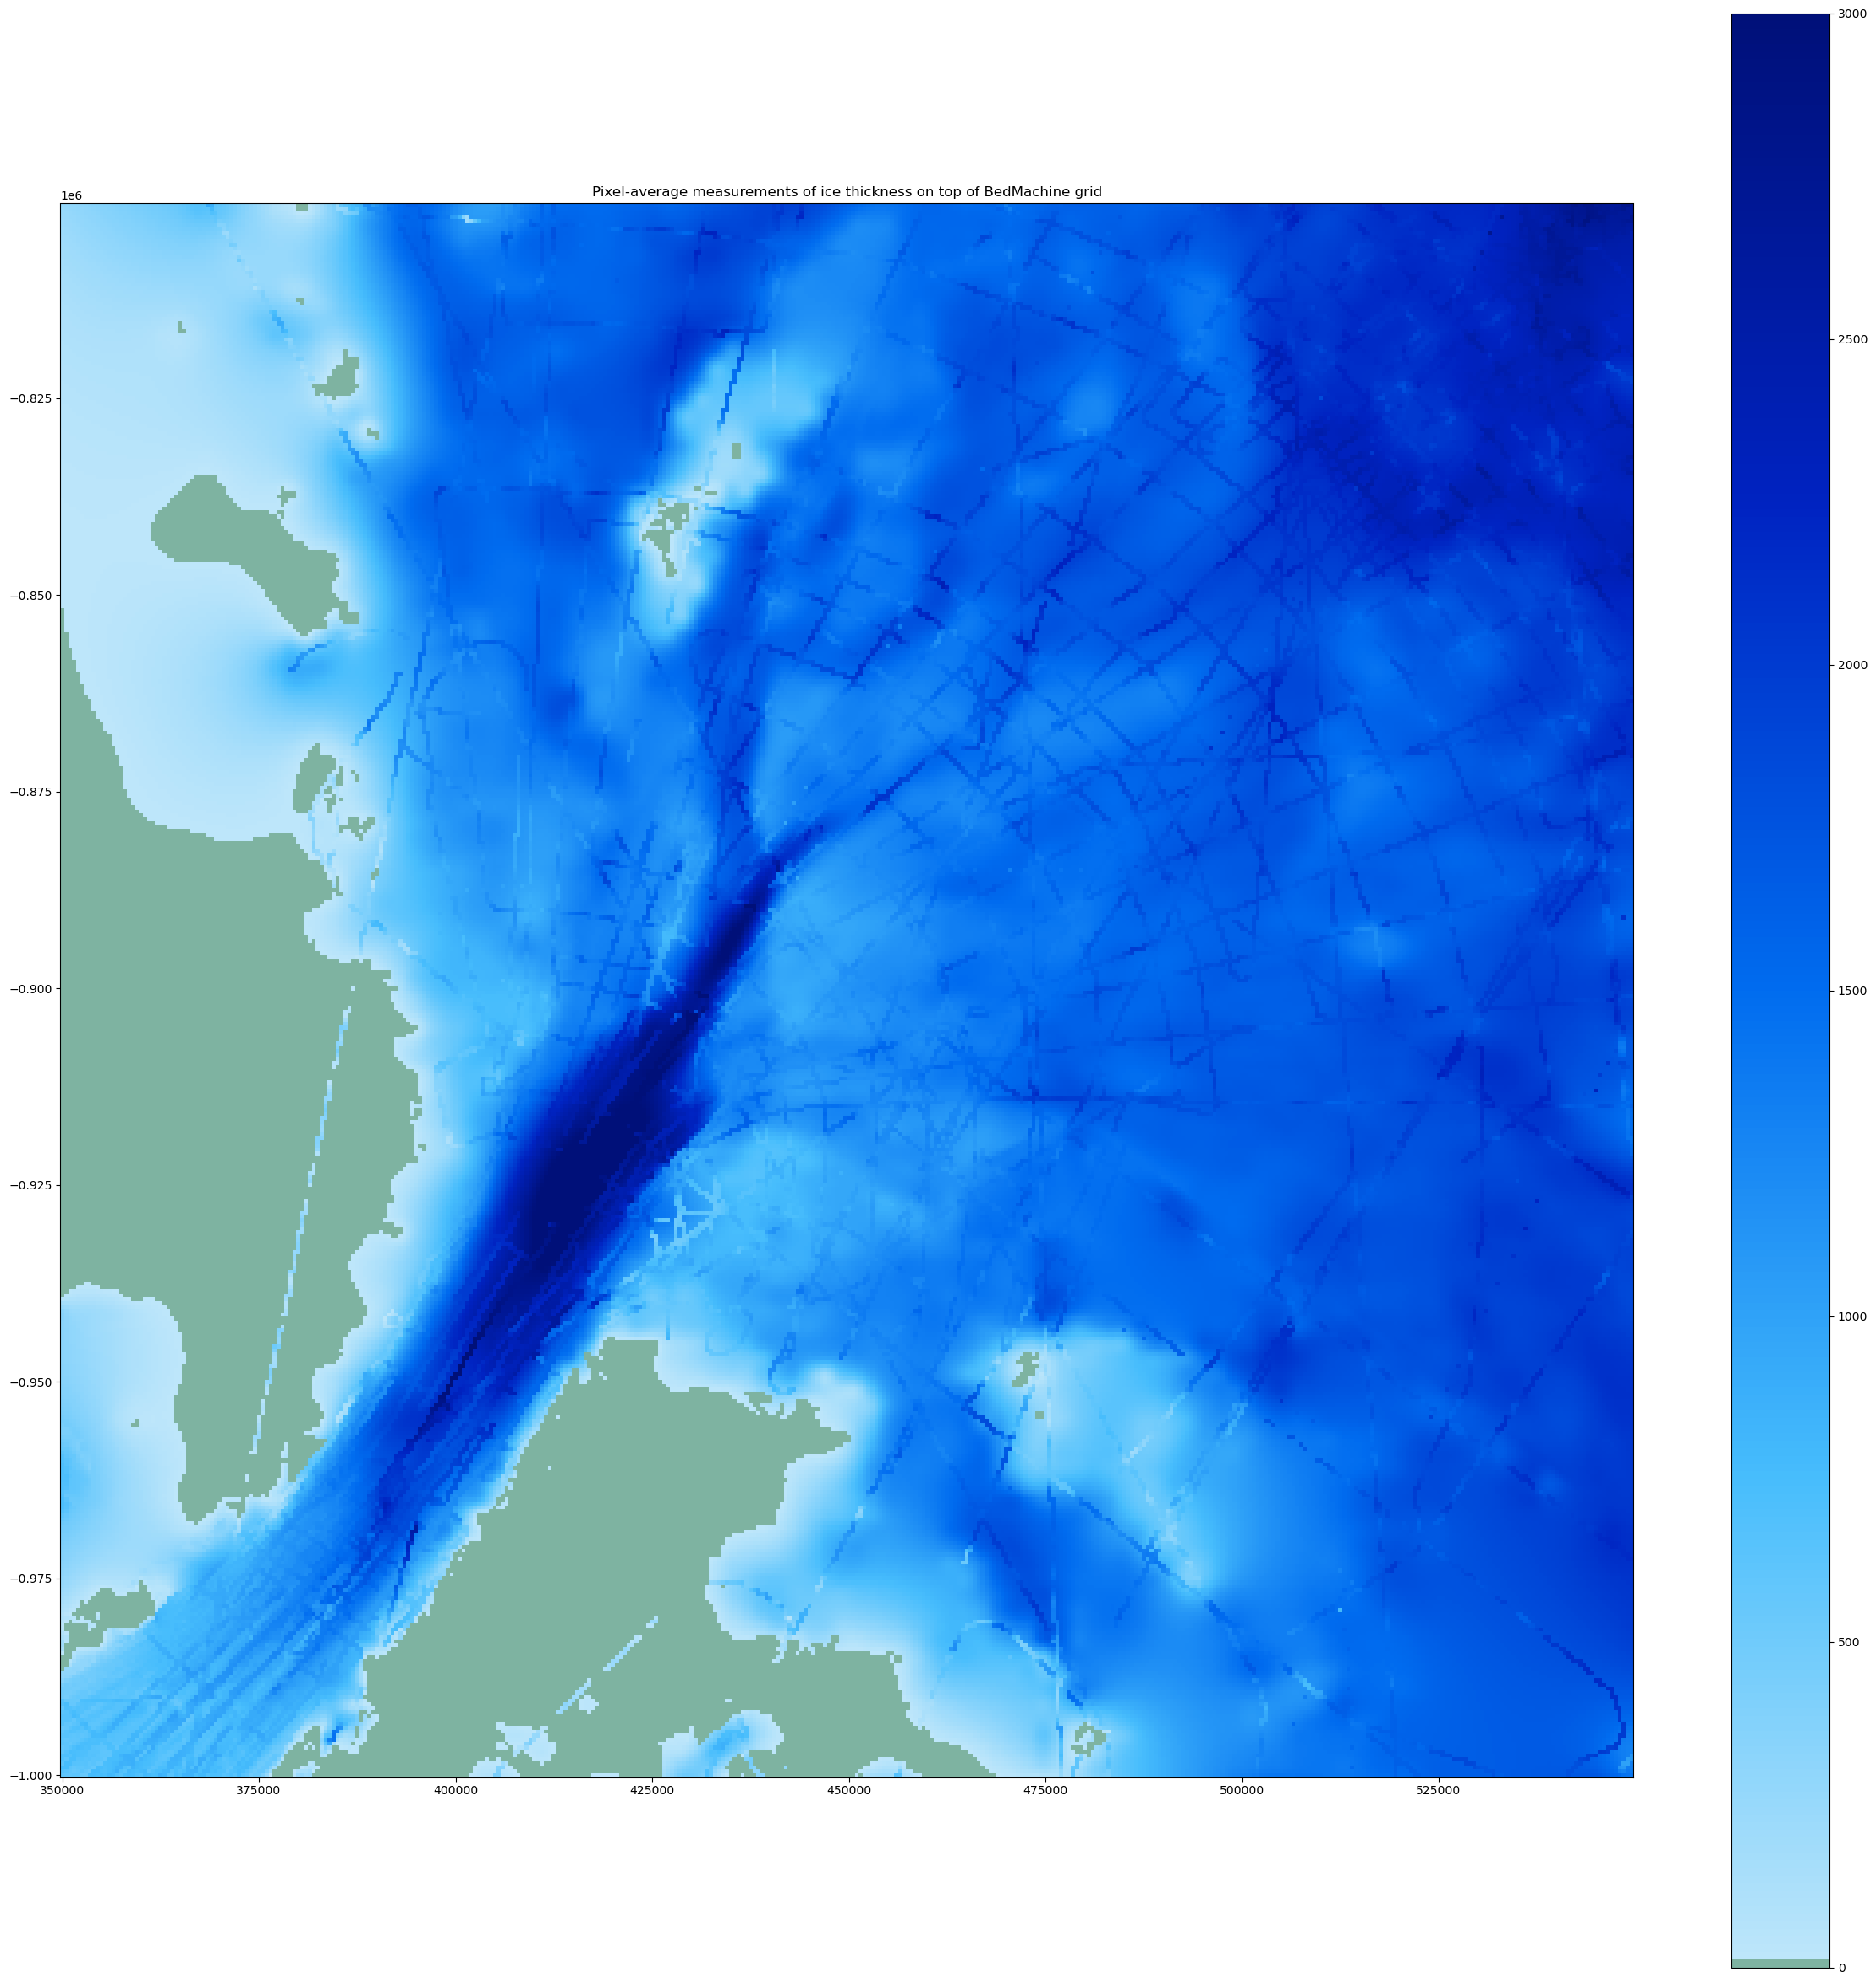

In [24]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3000)
# Plot cell mean over top
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_mean, cmap = icethickness_cmap, vmin = 0, vmax = 3000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Pixel-average measurements of ice thickness on top of BedMachine grid')
ax.set_aspect('equal')

In [37]:
print("Empty cells:")
print(np.isnan(byrd_bedmachine.pt_t_mean.values).sum())

print()
print("Non-empty cells:")
print((400*400) - np.isnan(byrd_bedmachine.pt_t_mean.values).sum())
# 27 k data points

Empty cells:
133085

Non-empty cells:
26915
